In [ ]:
#default_exp data.core

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.external import *
from local.notebook.showdoc import show_doc

In [ ]:
# Not exported since we only use it for examples
from PIL import Image

In [ ]:
#hide
torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

# Helper functions for processing data

> Functions for getting, splitting, and labeling data, etc

## Get, split, label, and show

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`), along with showing data (we'll only define image showing in this section).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

[PosixPath('/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3'),
 PosixPath('/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/7')]

In [ ]:
# export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
# export
def get_files(path, extensions=None, recurse=True, include=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`."
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `include` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png', recurse=False)
t7 = get_files(path/'train'/'7', extensions='.png', recurse=False)
t  = get_files(path/'train', extensions='.png', recurse=True)
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg', recurse=False)),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, include='train')))
t

(#709) [/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8055.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/9466.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/7778.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8824.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8228.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/9620.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8790.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/7497.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/7383.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/9324.png...]

In [ ]:
#hide
test_eq(len(get_files(path/'train'/'3', recurse=False)),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, include=['train', 'test'])),729)

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as CamelCase verbs ending in `er` to create these functions. `FileGetter` is a simple example of such a function creator.

In [ ]:
#export
def FileGetter(suf='', extensions=None, recurse=True, include=None):
    "Create `get_files` partial function that searches path suffix `suf` and passes along args"
    def _inner(o, extensions=extensions, recurse=recurse, include=include): return get_files(o/suf, extensions, recurse, include)
    return _inner

In [ ]:
fpng = FileGetter(extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path/'train'/'7')))
test_eq(len(t), len(fpng(path/'train', recurse=True)))
fpng_r = FileGetter(extensions='.png', recurse=True)
test_eq(len(t), len(fpng_r(path/'train')))

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#export
def get_image_files(path, recurse=True, include=None):
    "Get image files in `path` recursively."
    return get_files(path, extensions=image_extensions, recurse=recurse, include=include)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, include='train')))

In [ ]:
#export
def ImageGetter(suf='', recurse=True, include=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`"
    def _inner(o, recurse=recurse, include=include): return get_image_files(o/suf, recurse, include)
    return _inner

Same as `FileGetter`, but for image extensions.

In [ ]:
test_eq(len(get_files(path/'train', extensions='.png', recurse=True, include='3')),
        len(ImageGetter(   'train',                    recurse=True, include='3')(path)))

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

In [ ]:
# export
def RandomSplitter(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
src = list(range(30))
f = RandomSplitter(seed=42)
trn,val = f(src)
assert 0<len(trn)<len(src)
assert all(o not in val for o in trn)
test_eq(len(trn), len(src)-len(val))
# test random seed consistency
test_eq(f(src)[0], trn)
trn,val

((#24) [10,18,16,23,28,26,20,7,21,22...], (#6) [12,0,6,25,8,15])

In [ ]:
# export
def _grandparent_idxs(items, name): return mask2idxs(Path(o).parent.parent.name == name for o in items)

In [ ]:
# export
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
items = [path/'train/3/9932.png', path/'valid/7/7189.png', 
         path/'valid/7/7320.png', path/'train/7/9833.png',  
         path/'train/3/7666.png', path/'valid/3/925.png',
         path/'train/7/724.png', path/'valid/3/93055.png']
splitter = GrandparentSplitter()
test_eq(splitter(items),[[0,3,4,6],[1,2,5,7]])

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
# export
def parent_label(o, **kwargs):
    "Label `item` with the parent folder name."
    return o.parent.name if isinstance(o, Path) else o.split(os.path.sep)[-1]

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
test_eq(parent_label(items[0]), '3')
[parent_label(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
# export
def RegexLabeller(pat):
    "Label `item` with regex `pat`."
    pat = re.compile(pat)
    def _inner(o, **kwargs):
        res = pat.search(str(o))
        assert res,f'Failed to find "{pat}" in "{o}"'
        return res.group(1)
    return _inner

`RegexLabeller` is a very flexible function since it handles any regex search of the stringified item. For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
f = RegexLabeller(r'/(\d)/')
test_eq(parent_label(items[0]), '3')
[f(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

### Show

In [ ]:
#export
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL image on `ax`."
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # Handle pytorch axis order
    if isinstance(im,Tensor):
        im = to_cpu(im)
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show b&w images...

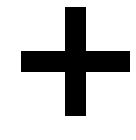

In [ ]:
im = make_cross_image()
ax = show_image(im, cmap="Greys", figsize=(2,2))

...and color images with standard `c*h*w` dim order...

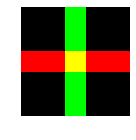

In [ ]:
im2 = make_cross_image(False)
ax = show_image(im2, figsize=(2,2))

...and color images with `h*w*c` dim order...

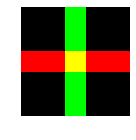

In [ ]:
im3 = im2.permute(1,2,0)
ax = show_image(im3, figsize=(2,2))

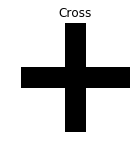

In [ ]:
ax = show_image(im, cmap="Greys", figsize=(2,2))
show_title("Cross", ax)

In [ ]:
#export
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

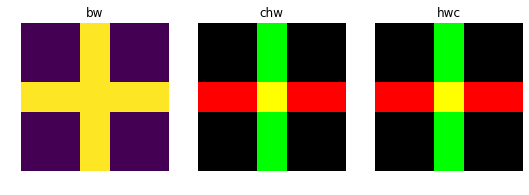

In [ ]:
show_image_batch(([im,im2,im3],['bw','chw','hwc']), items=3)

In [ ]:
#export
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

## Categorize -

In [ ]:
#export
class Category():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [ ]:
# export
class Categorize(Transform):
    "Reversible transform of category string to `vocab` id"
    order=1
    def __init__(self, vocab=None, subset_idx=None):
        self.vocab,self.subset_idx = vocab,subset_idx
        self.o2i = None if vocab is None else {v:k for k,v in enumerate(vocab)}
        
    def setup(self, dsrc):
        if not dsrc or self.vocab is not None: return
        dsrc = dsrc.train if self.subset_idx is None else dsrc.subset(self.subset_idx)
        self.vocab,self.o2i = uniqueify(dsrc, sort=True, bidir=True)
        setattr_parent(dsrc, 'vocab', self.vocab)

    def encodes(self, o)->Category: return self.o2i[o]
    def decodes(self, o):           return self.vocab[o]

In [ ]:
cat = Categorize(subset_idx=[0,1,2])
tds = TfmdDS(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['cat', 'dog'])
test_eq(tds.vocab, ['cat', 'dog'])
test_eq(cat('cat'), 0)
test_eq(cat.decode(1), 'dog')
test_eq(cat.return_type(), Category)
test_stdout(lambda: cat.return_type().show('cat'), 'cat')

## Multicategorize -

In [ ]:
#export
class MultiCategory():
    @staticmethod
    def show(o, ctx=None, sep=';', **kwargs): return show_title(sep.join(o), ctx=ctx)

In [ ]:
# export
class MultiCategorize(Categorize):
    "Reversible transform of multi-category strings to `vocab` id"
    def setup(self, dsrc):
        if not dsrc or self.vocab is not None: return
        dsrc = dsrc.train if self.subset_idx is None else dsrc.subset(self.subset_idx)
        vals = set()
        for b in dsrc: vals = vals.union(set(b))
        self.vocab,self.otoi = uniqueify(list(vals), sort=True, bidir=True)
        setattr_parent(dsrc, 'vocab', self.vocab)

    def encodes(self, o)->MultiCategory: return [self.otoi[o_] for o_ in o]
    def decodes(self, o):                return [self.vocab[o_] for o_ in o]

In [ ]:
cat = MultiCategorize(subset_idx=[0,1,2])
tds = TfmdDS([['b', 'c'], ['a'], ['a', 'c']], tfms=[cat])
test_eq(cat.vocab, ['a', 'b', 'c'])
test_eq(tds.vocab, ['a', 'b', 'c'])
test_eq(cat(['a', 'c']), [0,2])
test_eq(cat([]), [])
test_eq(cat.decode([1]), ['b'])
test_eq(cat.return_type(), MultiCategory)
test_stdout(lambda: cat.return_type().show(['a', 'c']), 'a;c')

In [ ]:
# export core
def one_hot(x, c):
    "One-hot encode `x` with `c` classes."
    res = torch.zeros(c, dtype=torch.uint8)
    res[L(x)] = 1.
    return res

In [ ]:
test_eq(one_hot([1,4], 5), tensor([0, 1, 0, 0, 1]).byte())
test_eq(one_hot([], 5), tensor([0, 0, 0, 0, 0]).byte())
test_eq(one_hot(2, 5), tensor([0, 0, 1, 0, 0]).byte())

In [ ]:
# export
class OneHotEncode(Transform):
    "One-hot encodes targets and optionally decodes with `vocab`"
    order=2
    def __init__(self, do_encode=True, vocab=None): self.do_encode,self.vocab = do_encode,vocab
    
    def setup(self, dsrc):
        if self.vocab is not None: 
            setattr_parent(dsrc, 'vocab', self.vocab)
            self.c = len(self.vocab)
        else: self.c = len(L(getattr(dsrc, 'vocab', None)))
        if self.c==0: warn("Couldn't infer the number of classes, please pass a `vocab` at init")
    
    def encodes(self, o)->Tensor: return one_hot(o, self.c) if self.do_encode else o
    def decodes(self, o): 
        return [self.vocab[i] if self.vocab else i for i,o_ in enumerate(o) if o_==1]

Work in conjunction with ` MultiCategorize` or on its own if you have one-hot encoded targets (pass a `vocab` for decoding and `do_encode=False` in this case)

In [ ]:
_tfm = OneHotEncode(vocab=['a', 'b', 'c'])
tds = TfmdDS([[1,2], [0], [0, 1]], tfms=[_tfm])
test_eq(_tfm([0,2]), tensor([1, 0, 1]).byte())
test_eq(_tfm.decode(tensor([0,1,1])), ['b','c'])

tds = TfmdDS([['b', 'c'], ['a'], ['a', 'c']], [[MultiCategorize(subset_idx=[0,1,2]), OneHotEncode()]])
test_eq(tds[1], tensor([1, 0, 0]).byte())
test_eq(tds.decode(tensor([0,1,1])), ['b','c'])
test_stdout(lambda: tds.show_at(2), 'a;c')

### End-to-end dataset example with MNIST

In [ ]:
items = get_image_files(path)
splits = splitter(items)
train,valid = (items[i] for i in splits)
train,valid

((#709) [/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8055.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/9466.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/7778.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8824.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8228.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/9620.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8790.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/7497.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/7383.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/9324.png...],
 (#699) [/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/valid/3/957.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/valid/3/9073.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/valid/3/8939.png,/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/valid/3/7401.png,/home/sgugger/git/fastai_docs/dev/data/m

In [ ]:
def img2tensor(im) -> TensorImage: return tensor(array(im))[None]

In [ ]:
timg = Transform(Image.open)
tfms = [[timg, img2tensor],
        [parent_label, Categorize(subset_idx=splits[0])]]
datasets = TfmdDS(items, tfms)
# NB: `DataSource` is an easier way to handle this common case
train_ds,valid_ds = map(datasets.subset, splits)

In [ ]:
x,y = train_ds[3]
xd,yd = train_ds.decode_at(3)
test_eq(parent_label(train[3]),yd)
test_eq(array(Image.open(train[3])),xd[0])

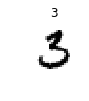

In [ ]:
train_ds.show_at(3, cmap="Greys", figsize=(1,1));

## TfmdDL -

In [ ]:
#export
def _DataLoader__getattr(self,k):
    try: return getattr(self.dataset, k)
    except AttributeError: raise AttributeError(k) from None
DataLoader.__getattr__ = _DataLoader__getattr

In [ ]:
#export
def get_samples(b, max_rows):
    if isinstance(b, Tensor): return b[:max_rows]
    return zip(*L(get_samples(b_, max_rows) if not isinstance(b,Tensor) else b_[:max_rows] for b_ in b))

In [ ]:
test_eq(get_samples(tensor([1,2,3]), 10), tensor([1, 2, 3]))
test_eq(list(get_samples([tensor([1,2,3]), tensor([4,5,6])], 10)), [(1, 4), (2, 5), (3, 6)])
test_eq(list(get_samples([tensor([1,2,3]), tensor([4,5,6])], 2)), [(1, 4), (2, 5)])
test_eq(list(get_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 10)), 
        [(1, (4, 7)), (2, (5, 8)), (3, (6, 9))])
test_eq(list(get_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 2)), [(1, (4, 7)), (2, (5, 8))])

In [ ]:
#export
@docs
class TfmdDL(GetAttr):
    "Transformed `DataLoader` using a `Pipeline` of `tfm`"
    _xtra = 'batch_size num_workers dataset sampler pin_memory'.split()
    
    def __init__(self, dataset, tfms=None, bs=16, shuffle=False,
                 sampler=None, batch_sampler=None, num_workers=1, **kwargs):
        self.dl = DataLoader(dataset, bs, shuffle, sampler, batch_sampler, num_workers=num_workers, **kwargs)
        if hasattr(dataset, 'tuple_tfms'): t = dataset.tuple_tfms.final_t
        elif hasattr(dataset, 'tfms'):     t = dataset.tfms.final_t
        else:                              t = None
        self.default,self.tfms = self.dl,Pipeline(tfms, t=t)
        for k,v in kwargs.items(): setattr(self,k,v)
        self.tfms.setup(self)
    
    def __len__(self): return len(self.dl)
    def __iter__(self): return (self.tfms(b, filt=getattr(self.dataset, 'filt', None)) for b in self.dl)
    def one_batch(self): return next(iter(self))
    def decode(self, b): 
        return getattr(self.dataset,'decode_batch',noop)(self.tfms.decode(b, filt=getattr(self.dataset, 'filt', None)))

    def show_batch(self, b=None, max_rows=1000, ctxs=None, **kwargs):
        "Show `b` (defaults to `one_batch`), a list of lists of pipeline outputs (i.e. output of a `DataLoader`)"
        if b is None: b=self.one_batch()
        b = self.tfms.decode(b, filt=getattr(self.dataset, 'filt', None))
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(get_samples(b, max_rows),ctxs): self.dataset.show(o, ctx=ctx)

    _docs = dict(decode="Decode `b` using `ds_tfm` and `tfm`",
                 show_batch="Show each item of `b`",
                 one_batch="Grab first batch of `dl`")

In [ ]:
class NegTfm(Transform):
    def encodes(self, x): return -x
    def decodes(self, x): return -x

def mk_string(x)->Category: return x    

dummy_tfm = Transform(mk_string)
start = range(50)
tl = TfmdList(start, dummy_tfm)
tdl = TfmdDL(tl, NegTfm(), bs=4)
test_eq(start, tdl.dataset)
test_eq(len(tdl), (len(tl)-1)//4+1)
test_eq(tdl.batch_size, 4)

### Methods

In [ ]:
show_doc(TfmdDL.one_batch)

<h4 id="<code>TfmdDL.one_batch</code>" class="doc_header"><code>TfmdDL.one_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#TfmdDL--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDL.one_batch</code>()

Grab first batch of `dl`

In [ ]:
b = tdl.one_batch()
test_eq(tensor([0,-1,-2,-3]), b)

In [ ]:
show_doc(TfmdDL.decode)

<h4 id="<code>TfmdDL.decode</code>" class="doc_header"><code>TfmdDL.decode</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#TfmdDL--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDL.decode</code>(**`b`**)

Decode `b` using `ds_tfm` and `tfm`

In [ ]:
test_eq(tdl.decode(b), tensor([0,1,2,3]))

In [ ]:
show_doc(TfmdDL.show_batch)

<h4 id="<code>TfmdDL.show_batch</code>" class="doc_header"><code>TfmdDL.show_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#TfmdDL--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDL.show_batch</code>(**`b`**=*`None`*, **`max_rows`**=*`1000`*, **`ctxs`**=*`None`*, **\*\*`kwargs`**)

Show each item of `b`

In [ ]:
test_stdout(tdl.show_batch, """tensor(0)
tensor(1)
tensor(2)
tensor(3)""")

## Cuda -

In [ ]:
# export
@docs
class Cuda(Transform):
    "Move batch to `device` (defaults to `defaults.device`)"
    def __init__(self,device=None): self.device=default_device() if device is None else device        
    def encodes(self, b): return to_device(b, self.device)
    def decodes(self, b): return to_cpu(b)
    
    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")

In [ ]:
tfm = Cuda()

In [ ]:
show_doc(Cuda.encodes)

<h4 id="<code>Cuda.encodes</code>" class="doc_header"><code>Cuda.encodes</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#Cuda--" class="source_link" style="float:right">[source]</a></h4>

> <code>Cuda.encodes</code>(**`b`**)

Move batch to [`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)

Note that, like all `Transform`s, `encodes` is called by `tfm()` and `decodes` is called by `tfm.decode()`.

In [ ]:
t = tfm(tensor(1))
test_eq(t,1)
test_eq(t.type(),'torch.cuda.LongTensor')

In [ ]:
show_doc(Cuda.decodes)

<h4 id="<code>Cuda.decodes</code>" class="doc_header"><code>Cuda.decodes</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#Cuda--" class="source_link" style="float:right">[source]</a></h4>

> <code>Cuda.decodes</code>(**`b`**)

Return batch to CPU

In [ ]:
t = tfm.decode(t)
test_eq(t,1)
test_eq(t.type(),'torch.LongTensor')

## ByteToFloatTensor -

In [ ]:
#export
class TensorMask(TensorImage): pass

In [ ]:
# export
@docs
class ByteToFloatTensor(Transform):
    "Transform image to float tensor, optionally dividing by 255 (e.g. for images)."
    order=20 #Need to run after CUDA if on the GPU
    def __init__(self, div=True, div_mask=False): self.div,self.div_mask = div,div_mask
    def encodes(self, o:TensorImage): return o.float().div_(255.) if self.div else o.float()
    def decodes(self, o:TensorImage): return o.clamp(0., 1.) if self.div else o
    def encodes(self, o:TensorMask): return o.div_(255.).long() if self.div_mask else o.long()
    def decodes(self, o:TensorMask): return o
    
    _docs=dict(encodes="Convert items matching `mask` to float and optionally divide by 255",
               decodes="Clamp to (0,1) items matching `mask`")

In [ ]:
t = (tensor(1),tensor(2))
tfm = ByteToFloatTensor()
tfm.accept_types([TensorImage, Category])
ft = tfm(t)
test_eq([1./255, 2], ft)
test_eq(ft[0].type(),'torch.FloatTensor')
test_eq(ft[1].type(),'torch.LongTensor')

## Normalization -

In [ ]:
# export
@docs
class Normalize(Transform):
    "Normalize/denorm batch of `TensorImage`"
    order=99
    def __init__(self, mean, std): self.mean,self.std = mean,std   
    def encodes(self, x:TensorImage): return (x-self.mean) / self.std
    def decodes(self, x:TensorImage): return (x*self.std ) + self.mean
    
    _docs=dict(encodes="Normalize batch", decodes="Denormalize batch")

In [ ]:
# export
def broadcast_vec(dim, ndim, *t, cuda=True):
    "Make a vector broadcastable over `dim` (out of `ndim` total) by prepending and appending unit axes"
    v = [1]*ndim
    v[dim] = -1
    f = to_device if cuda else noop
    return [f(tensor(o).view(*v)) for o in t]

In [ ]:
mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)
dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(mean,std)]
tdl = TfmdDL(train_ds, dl_tfms, bs=4)

In [ ]:
x,y  = tdl.one_batch()
xd,yd = tdl.decode((x,y))[0]

In [ ]:
test_eq(x.type(), 'torch.cuda.FloatTensor')
test_eq(xd.type(), 'torch.FloatTensor')
assert x.mean()<0.0
assert x.std()>0.5
assert 0<xd.mean()<1
assert 0<xd.std()<0.5

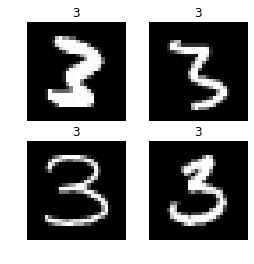

In [ ]:
_,axs = plt.subplots(2,2, figsize=(4,4))
tdl.show_batch((x,y), ctxs=axs.flatten())

## DataBunch -

In [ ]:
# export
@docs
class DataBunch(GetAttr):
    "Basic wrapper around several `DataLoader`s."
    _xtra = 'one_batch show_batch dataset'.split()

    def __init__(self, *dls): self.dls,self.default = dls,dls[0]
    def __getitem__(self, i): return self.dls[i]

    train_dl,valid_dl = add_props(lambda i,x: x[i])
    train_ds,valid_ds = add_props(lambda i,x: x[i].dataset)
    
    _docs=dict(__getitem__="Retrieve `DataLoader` at `i` (`0` is training, `1` is validation)",
              train_dl="Training `DataLoader`",
              valid_dl="Validation `DataLoader`",
              train_ds="Training `Dataset`",
              valid_ds="Validation `Dataset`")

In [ ]:
dbch = DataBunch(tdl,tdl)
x,y  = dbch.train_dl.one_batch()
x2,y2 = next(iter(tdl))
test_eq(x,x2)
x2,y2 = dbch.one_batch()
test_eq(x,x2)

In [ ]:
show_doc(DataBunch.__getitem__)

<h4 id="<code>DataBunch.__getitem__</code>" class="doc_header"><code>DataBunch.__getitem__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#DataBunch--" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBunch.__getitem__</code>(**`i`**)

Retrieve [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) at `i` (`0` is training, `1` is validation)

In [ ]:
x2,y2 = dbch[0].one_batch()
test_eq(x,x2)

In [ ]:
show_doc(DataBunch.train_dl, name="train_dl")

<h4 id="<code>train_dl</code>" class="doc_header"><code>train_dl</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Training [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [ ]:
show_doc(DataBunch.valid_dl, name="valid_dl")

<h4 id="<code>valid_dl</code>" class="doc_header"><code>valid_dl</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Validation [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [ ]:
show_doc(DataBunch.train_ds, name="train_ds")

<h4 id="<code>train_ds</code>" class="doc_header"><code>train_ds</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Training `Dataset`

In [ ]:
show_doc(DataBunch.valid_ds, name="valid_ds")

<h4 id="<code>valid_ds</code>" class="doc_header"><code>valid_ds</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Validation `Dataset`

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial-meta.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_vision_augment.ipynb.
Converted 09_data_block.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 13_callback_schedule.ipynb.
Converted 14_callback_hook.ipynb.
Converted 15_callback_progress.ipynb.
Converted 16_callback_tracker.ipynb.
Converted 17_callback_fp16.ipynb.
Converted 30_text_core.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
